In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

train_df = pd.read_csv(r'/content/drive/My Drive/bert_data/l3cube_mr_train.csv')
val_df = pd.read_csv(r'/content/drive/My Drive/bert_data/l3cube_mr_val.csv')
test_df = pd.read_csv(r'/content/drive/My Drive/bert_data/l3cube_mr_test.csv')

def preprocess_df(df):
    df = df.drop('uid', axis=1)
    df.columns = ['Text', 'Type']
    return df
train_df = preprocess_df(train_df)
val_df = preprocess_df(val_df)
test_df = preprocess_df(test_df)

X_train = list(train_df['Text'].values)
y_train = list(train_df['Type'].values)

X_valid = list(val_df['Text'].values)
y_valid = list(val_df['Type'].values)

X_test = list(test_df['Text'].values)
y_test = list(test_df['Type'].values)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("l3cube-pune/mahahate-bert")


In [ ]:
def generate_dataset(X, y, tokenizer):
    encodings = tokenizer.batch_encode_plus(X,
                                           truncation=True,
                                           padding=True,
                                           max_length=128,
                                           return_tensors='pt',
                                           add_special_tokens=True)

    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']

    y = torch.tensor(y)
    dataset = TensorDataset(input_ids, attention_mask, y)
    return dataset
train_dataset = generate_dataset(X_train, y_train, tokenizer)
valid_dataset = generate_dataset(X_valid, y_valid, tokenizer)

In [ ]:
def get_data_loader(dataset, sampler):
    return DataLoader(dataset=dataset, sampler=sampler(dataset), batch_size=32)

train_loader = get_data_loader(train_dataset, RandomSampler)
validation_loader = get_data_loader(valid_dataset, SequentialSampler)

In [ ]:
model = BertForSequenceClassification.from_pretrained("l3cube-pune/mahahate-bert", num_labels=2)
model.to(device)
print("Imported model!")

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

Imported model!


In [ ]:
num_epochs = 8
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def compute_accuracy(preds, labels):
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(preds == labels) / len(labels)

import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# Train function remains the same
def train():
    total_loss = 0.0
    total_acc = 0.0
    model.train()
    for step, batch in enumerate(train_loader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())

        loss = outputs.loss
        logits = outputs.logits

        total_loss = total_loss + loss.item()
        total_acc = total_acc + compute_accuracy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    return avg_loss, avg_acc

# Evaluation function remains the same
def evaluate():
    total_loss = 0.0
    total_acc = 0.0
    model.eval()  # Switch model to evaluation mode
    true_labels = []
    predictions = []

    for step, batch in enumerate(validation_loader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(validation_loader)))
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())

        loss = outputs.loss
        logits = outputs.logits

        total_loss = total_loss + loss.item()
        total_acc = total_acc + compute_accuracy(logits, labels)

        logits = logits.detach().cpu().numpy()
        logits = np.argmax(logits, axis=1).flatten()
        labels = labels.detach().cpu().numpy().flatten()

        true_labels.extend(labels)
        predictions.extend(logits)

    avg_loss = total_loss / len(validation_loader)
    avg_acc = total_acc / len(validation_loader)
    macro_f1_score = classification_report(true_labels, predictions, output_dict=True)['macro avg']['f1-score']

    return avg_loss, avg_acc, macro_f1_score

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_f1 = 0.0



 Epoch 1 / 8
  Batch    50  of    938.
  Batch   100  of    938.
  Batch   150  of    938.
  Batch   200  of    938.
  Batch   250  of    938.
  Batch   300  of    938.
  Batch   350  of    938.
  Batch   400  of    938.
  Batch   450  of    938.
  Batch   500  of    938.
  Batch   550  of    938.
  Batch   600  of    938.
  Batch   650  of    938.
  Batch   700  of    938.
  Batch   750  of    938.
  Batch   800  of    938.
  Batch   850  of    938.
  Batch   900  of    938.
  Batch    50  of    118.
  Batch   100  of    118.

Training Accuracy: 0.947 | Training Loss: 0.140 | Validation Accuracy: 0.904 | Validation Loss: 0.249 | F1 Score: 0.905

 Epoch 2 / 8
  Batch    50  of    938.
  Batch   100  of    938.
  Batch   150  of    938.
  Batch   200  of    938.
  Batch   250  of    938.
  Batch   300  of    938.
  Batch   350  of    938.
  Batch   400  of    938.
  Batch   450  of    938.
  Batch   500  of    938.
  Batch   550  of    938.
  Batch   600  of    938.
  Batch   650  of  

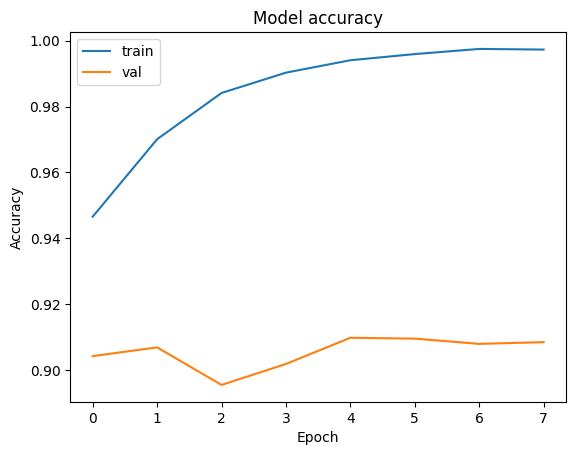

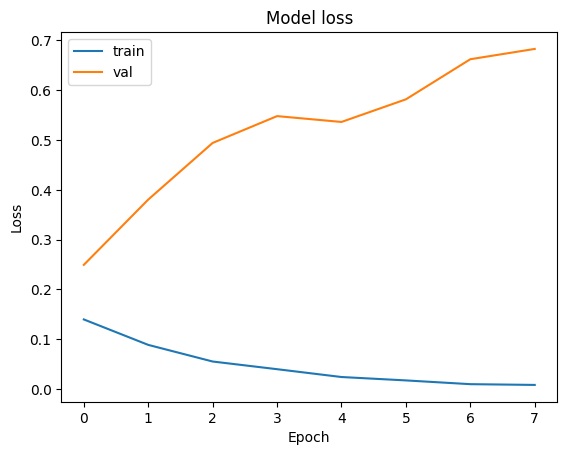

In [ ]:
import os
# Initialize the lists
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

# Define paths
model_path = '/content/drive/My Drive/bert_data/marathi_bert_model.pt'
metrics_path = '/content/drive/My Drive/bert_data/metrics.pt'

# Check if model and metrics file exists in the specified Google Drive path
if os.path.exists(model_path) and os.path.exists(metrics_path):
    metrics = torch.load(metrics_path)
    train_losses = metrics['train_losses']
    train_accs = metrics['train_accs']
    valid_losses = metrics['valid_losses']
    valid_accs = metrics['valid_accs']

else:
    best_f1 = 0
    for epoch in range(num_epochs):
        print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
        train_loss, train_acc = train()
        valid_loss, valid_acc, f1_score = evaluate()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        if f1_score > best_f1:
            best_f1 = f1_score
            torch.save(model, model_path)

        print(f'\nTraining Accuracy: {train_acc:.3f} | Training Loss: {train_loss:.3f} | Validation Accuracy: {valid_acc:.3f} | Validation Loss: {valid_loss:.3f} | F1 Score: {f1_score:.3f}')

    # Save the metrics
    metrics = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'valid_losses': valid_losses,
        'valid_accs': valid_accs,
    }
    torch.save(metrics, metrics_path)

# Plotting remains the same
import matplotlib.pyplot as plt

plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
load_path = '/content/drive/My Drive/bert_data/marathi_bert_model.pt'  # TODO: Update this to your path
model = torch.load(load_path)
model = model.to(device)


In [ ]:
test_dataset = generate_dataset(X_test, y_test, tokenizer)
test_loader = get_data_loader(test_dataset, SequentialSampler)

# Test evaluation function
def test_evaluate():
    total_loss = 0.0
    total_acc = 0.0
    model.eval()  # Switch model to evaluation mode
    true_labels = []
    predictions = []

    for step, batch in enumerate(test_loader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_loader)))
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())

        loss = outputs.loss
        logits = outputs.logits

        total_loss = total_loss + loss.item()
        total_acc = total_acc + compute_accuracy(logits, labels)

        logits = logits.detach().cpu().numpy()
        logits = np.argmax(logits, axis=1).flatten()
        labels = labels.detach().cpu().numpy().flatten()

        true_labels.extend(labels)
        predictions.extend(logits)

    avg_loss = total_loss / len(test_loader)
    avg_acc = total_acc / len(test_loader)
    macro_f1_score = classification_report(true_labels, predictions, output_dict=True)['macro avg']['f1-score']

    return avg_loss, avg_acc, macro_f1_score

# Run the test evaluation
test_loss, test_acc, f1_score = test_evaluate()
print(f'\nTest Accuracy: {test_acc:.3f} | Test Loss: {test_loss:.3f} | F1 Score: {f1_score:.3f}')

  Batch    50  of    118.
  Batch   100  of    118.

Test Accuracy: 0.903 | Test Loss: 0.557 | F1 Score: 0.904
